# Look for enrichments of GWAS disorder genes

In [16]:
%cd work/notebooks

# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from enrichments import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

[Errno 2] No such file or directory: 'work/notebooks'
/home/jovyan/work/notebooks
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [406]:
def get_gwas(filename='li2018'):
    df = pd.read_csv(f"../data/gwas/{filename}.csv")
    df = (df.melt(var_name='label', value_name='gene').dropna()
          .assign(gene = lambda x: x['gene'].str.replace('\\..*','', regex=True)) #drop variants
          .drop_duplicates()
    )
    return df

gwas_genes = get_gwas('trubetskoy2022')
# get_gwas('reay2020')
# get_gwas('grove2019_wray2018_pardinas2018')
# get_gwas('matoba2020_als2022_ripke2020')

In [17]:
dme_3d_ds5 = gradientVersion(approach='dm').fit('hcp_3donors_ds5')
weights = dme_3d_ds5.weights.iloc[:,:3]
nulls = shuffle_gene_weights(weights, n=5000, rank=False)


New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [407]:
gwas_genes_dict = {
    'grove2019_wray2018_pardinas2018': get_gwas('grove2019_wray2018_pardinas2018'),
    # 'pardinas2018_other': get_gwas('pardinas2018_other'),
    'matoba2020_als2022_ripke2020': get_gwas('matoba2020_als2022_ripke2020'),
    'li2018': get_gwas('li2018'),
    'li2018_hiC_strict': get_gwas('li2018_hiC_strict'),
    'reay2020': get_gwas('reay2020'),
    'hammerschlag2020_yang2021_trubetskoy2022': get_gwas('hammerschlag2020_yang2021_trubetskoy2022')
}

gwas_stats_dict = {
    name: compute_null_p(*compute_enrichments(weights, nulls, gwas_genes, posneg='abs'))
    for name, gwas_genes in gwas_genes_dict.items()
}

In [260]:
# gwas_genes.pop('pain2019_yang2021_trubetskoy2022')
# gwas_genes = get_gwas('hammerschlag2020_yang2021_trubetskoy2022')
# gwas_stats_dict['hammerschlag2020_yang2021_trubetskoy2022']=compute_null_p(*compute_enrichments(weights, nulls, gwas_genes, posneg='abs'))

In [408]:
gwas_stats = (pd.concat(gwas_stats_dict).reset_index(0).rename({'level_0':'data'}, axis=1)
              .assign(label = lambda x: [f"{label}\n({n_matches}/{n_genes})" for label, n_matches, n_genes in
                                        zip(x['label'], x['n_matches'], x['n_genes'])]))
gwas_stats.head(10)

,data,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,grove2019_wray2018_pardinas2018,ASD\n(9/15),G1,0.5776,0.010642,0.010301,0.001500,0.227628,True,0.8448,0.95040,False,15,9
1,grove2019_wray2018_pardinas2018,ASD\n(9/15),G2,0.8972,0.011930,0.009099,0.002184,1.295906,True,0.2056,0.58230,False,15,9
2,grove2019_wray2018_pardinas2018,ASD\n(9/15),G3,0.3850,0.008243,0.008971,0.002177,-0.334560,False,0.7700,0.95040,False,15,9
3,grove2019_wray2018_pardinas2018,MDD\n(62/153),G1,0.7378,0.010647,0.010283,0.000563,0.645934,True,0.5244,0.78660,False,153,62
4,grove2019_wray2018_pardinas2018,MDD\n(62/153),G2,0.1226,0.008141,0.009103,0.000831,-1.157680,False,0.2452,0.58230,False,153,62
5,grove2019_wray2018_pardinas2018,MDD\n(62/153),G3,0.8166,0.009787,0.009002,0.000848,0.924790,True,0.3668,0.66024,False,153,62
6,grove2019_wray2018_pardinas2018,SCZ\n(11/22),G1,0.4952,0.010320,0.010293,0.001338,0.020250,False,0.9904,0.99040,False,22,11
7,grove2019_wray2018_pardinas2018,SCZ\n(11/22),G2,0.8706,0.011406,0.009123,0.001996,1.144110,True,0.2588,0.58230,False,22,11
8,grove2019_wray2018_pardinas2018,SCZ\n(11/22),G3,0.0038,0.004169,0.009024,0.001998,-2.429129,False,0.0076,0.06840,False,22,11
0,matoba2020_als2022_ripke2020,ASD\n(106/372),G1,0.7744,0.010611,0.010294,0.000425,0.746127,True,0.4512,0.67680,False,372,106


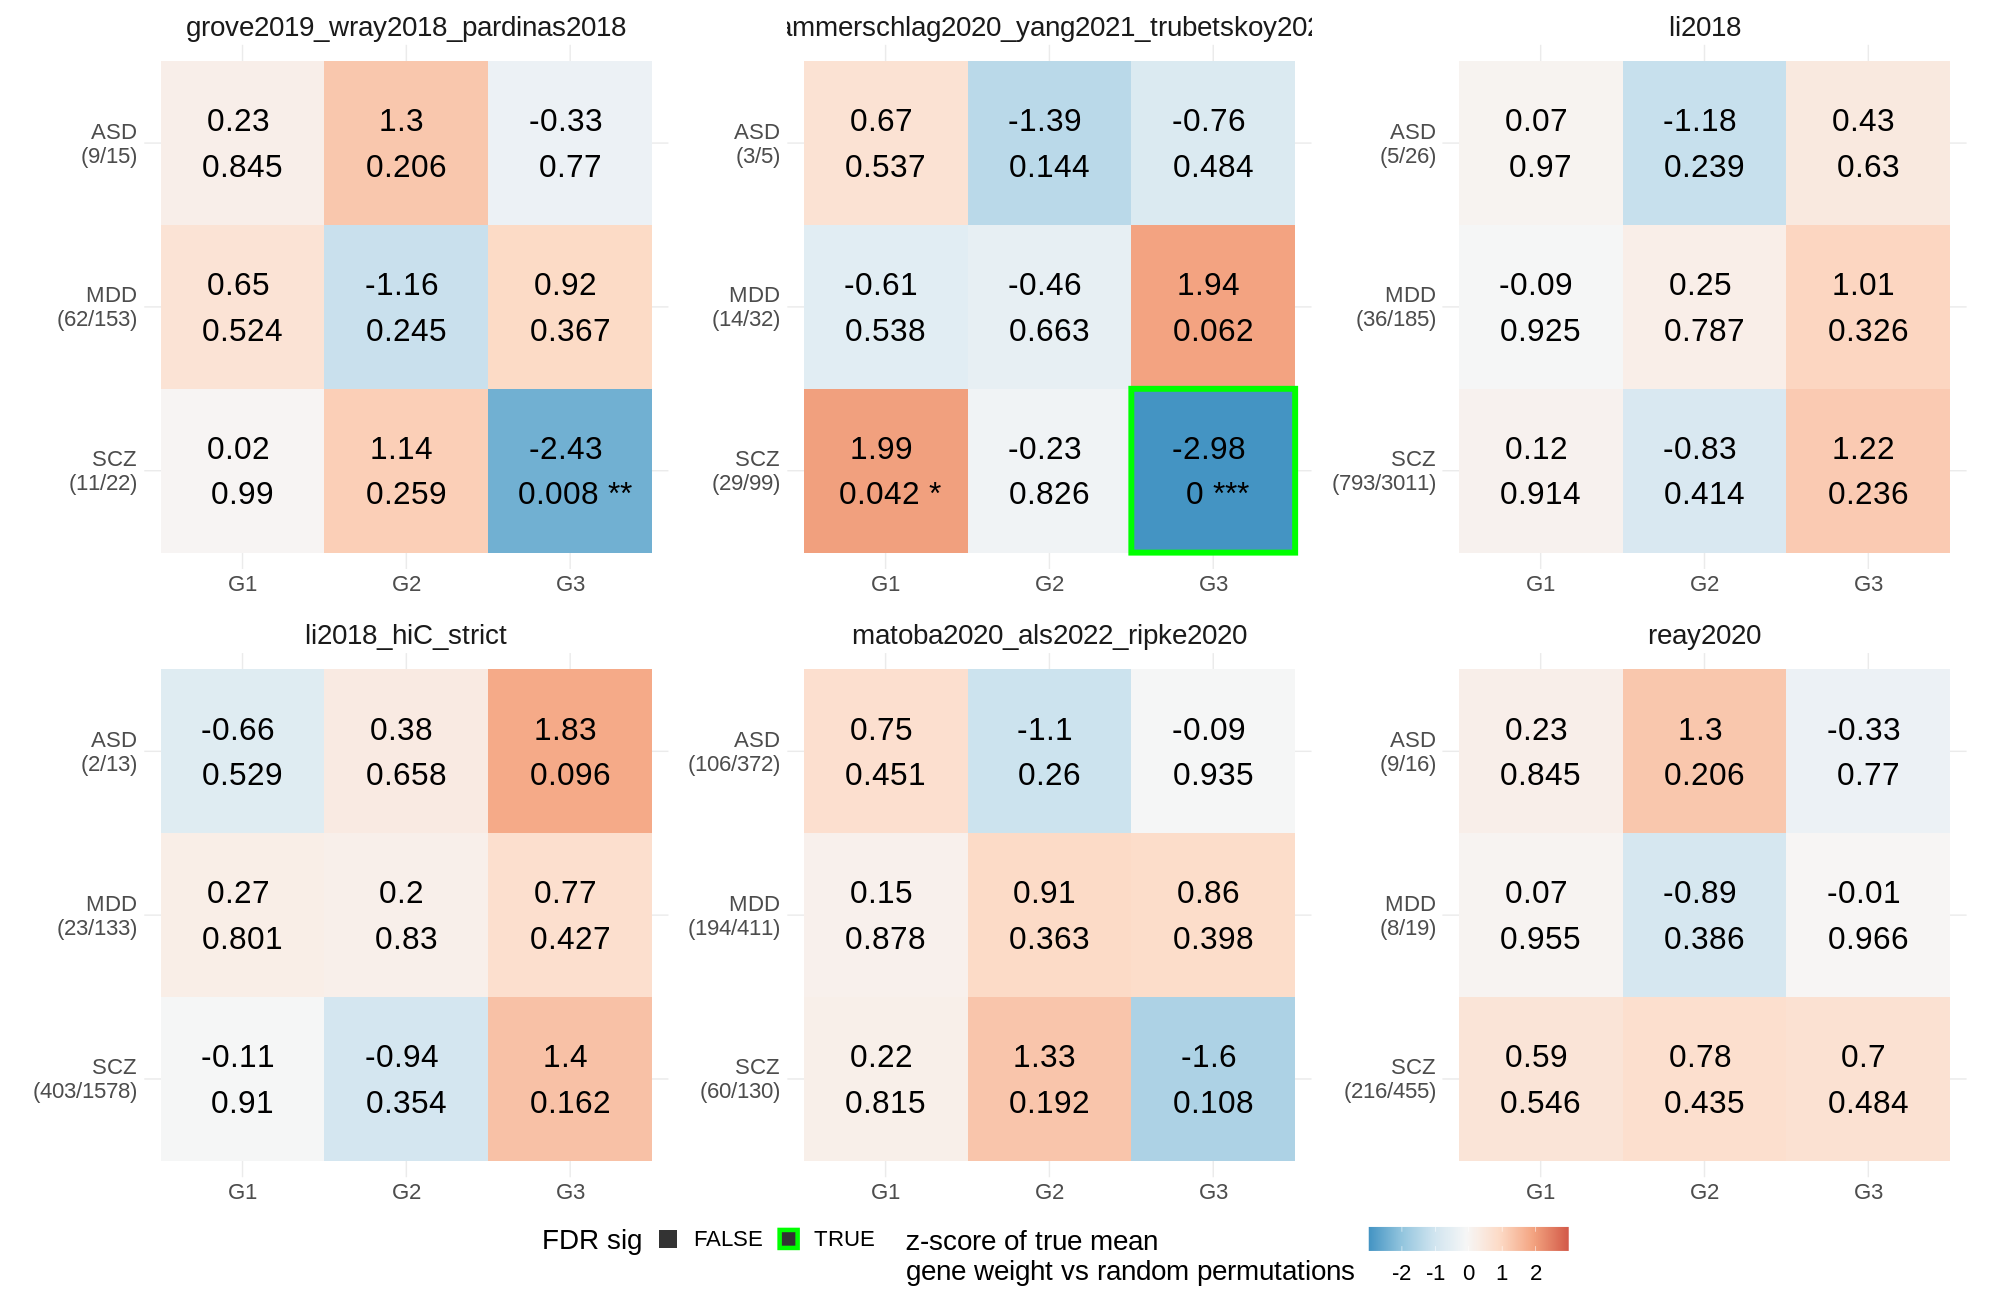

In [409]:
%%R -i gwas_stats -w 20 -h 13 --units in -r 100
source("../code/enrichmentsPlots.R")
gwas_stats %>% rename(version = data) %>% arrange(version) %>% 
plot_enrichment_heatmaps(scales='free') + theme(legend.position='bottom') +
guides(fill=guide_colourbar(title='z-score of true mean\ngene weight vs random permutations', barwidth=10))

## Scatter plot?

In [478]:
trubetskoy_genes = (
    # pd.read_csv("../data/gwas/trubetskoy2022_data.csv")
    pd.read_csv("../data/gwas/trubetskoy2022_allgenes_fetal.csv")
    [['Gene', 'b_GWAS', 'b_eQTL', 'b_SMR', 'p_GWAS', 'p_eQTL', 'p_SMR', 'p_HEIDI']]
    .assign(gene = lambda x: x['Gene'].str.replace('\\..*','', regex=True)).drop('Gene',axis=1)
    .groupby('gene').mean()
    .melt(ignore_index=False, var_name='metric', value_name='value')
)
df_trubetskoy = (
    trubetskoy_genes.join(dme_3d_ds5.weights.iloc[:,:3].set_axis(['G1','G2','G3'],axis=1))
    .dropna().melt(id_vars=['metric', 'value'], var_name='G', value_name='weight')
)
df_trubetskoy

,metric,value,G,weight
0,b_GWAS,1.501130e-03,G1,-0.017031
1,b_eQTL,-5.098440e-01,G1,-0.017031
2,b_SMR,-2.944290e-03,G1,-0.017031
3,p_GWAS,8.740000e-01,G1,-0.017031
4,p_eQTL,1.750000e-09,G1,-0.017031
...,...,...,...,...
3121,b_SMR,6.146960e-04,G3,0.006638
3122,p_GWAS,9.710000e-01,G3,0.006638
3123,p_eQTL,4.650000e-10,G3,0.006638
3124,p_SMR,9.710000e-01,G3,0.006638


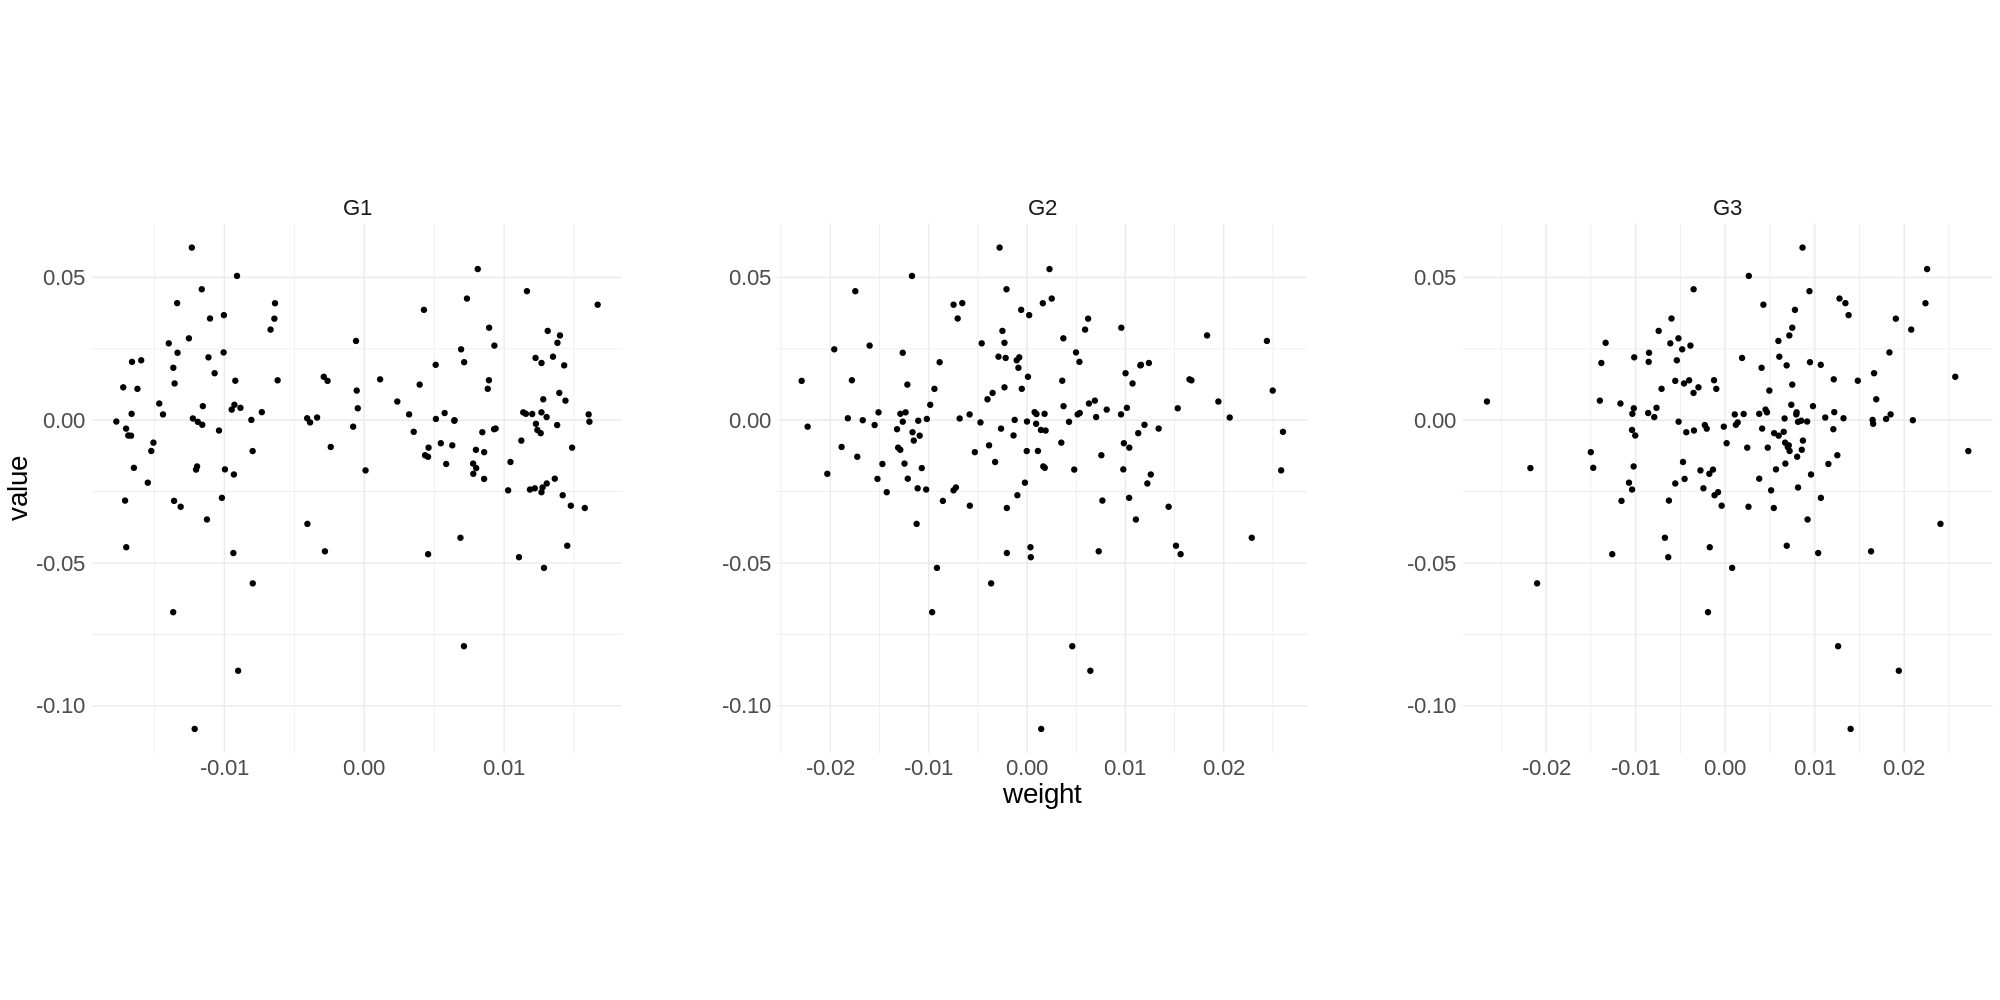

In [483]:
%%R -i df_trubetskoy -w 20 -h 10 --units in -r 100
df_trubetskoy %>%
filter(metric == 'b_SMR') %>%
ggplot(aes(weight, value)) + 
facet_wrap(~ G, scales='free') +
geom_point() +
theme_minimal() +
theme(panel.spacing=unit(5,'lines'),
      aspect.ratio=1,
      text=element_text(size=20)
)


## Overlaps

In [404]:
a = gwas_genes_dict['grove2019_wray2018_pardinas2018'].query("label=='SCZ'").set_index('gene').drop('label', axis=1).assign(pardinas=1)
b = gwas_genes_dict['matoba2020_als2022_ripke2020'].query("label=='SCZ'").set_index('gene').drop('label', axis=1).assign(ripke=1)
c = gwas_genes_dict['hammerschlag2020_yang2021_trubetskoy2022'].query("label=='SCZ'").drop_duplicates().set_index('gene').drop('label', axis=1).assign(trubetskoy=1)

In [422]:
x = pd.concat([a,c], axis=1).fillna(0)
pd.crosstab(x.pardinas, x.trubetskoy)

trubetskoy,0.0,1.0
pardinas,,
0.0,0,87
1.0,10,12


In [411]:
pd.concat([a,b,c], axis=1).assign(count=1).fillna(0).groupby(['trubetskoy','pardinas','ripke']).sum()

count
trubetskoy pardinas ripke       
0.0        0.0      1.0       75
           1.0      0.0        9
                    1.0        1
1.0        0.0      0.0       43
                    1.0       44
           1.0      0.0        2
                    1.0       10

In [272]:
rare_genes = pd.read_csv("../data/rare_genes_konrad.csv").melt(var_name='label', value_name='gene').dropna()

In [362]:
compute_null_p(*compute_enrichments(weights, nulls, rare_genes, posneg='abs'))

,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,ASD,G1,0.46,1.03e-02,1.03e-02,5.98e-04,-0.07,False,0.93,0.99,False,102,52
1,ASD,G2,0.49,9.07e-03,9.11e-03,9.02e-04,-0.04,False,0.99,0.99,False,102,52
2,ASD,G3,0.93,1.03e-02,8.98e-03,9.17e-04,1.49,True,0.14,0.43,False,102,52
3,SCZ,G1,0.47,1.02e-02,1.03e-02,1.22e-03,-0.06,False,0.94,0.99,False,32,13
4,SCZ,G2,0.99,1.36e-02,9.06e-03,1.83e-03,2.50,True,0.01,0.08,False,32,13
5,SCZ,G3,0.56,9.23e-03,9.01e-03,1.86e-03,0.12,True,0.87,0.99,False,32,13


In [284]:
rare_genes

,label,gene
0,ASD,CHD8
1,ASD,SCN2A
2,ASD,SYNGAP1
3,ASD,ADNP
4,ASD,FOXP1
...,...,...
129,SCZ,OR4P4
130,SCZ,SLC22A11
131,SCZ,ANKRD12
132,SCZ,SV2A


In [359]:
from scipy.stats import fisher_exact
asd_genes = rare_genes.set_index('label').loc['ASD',:].values.squeeze()

def fisher_test_asd(i=0):
    df_asd = (weights[i].rank(ascending=True)<1000).to_frame('top1k').assign(ASD=lambda x: np.isin(x.index, asd_genes))
    table = pd.crosstab(df_asd['top1k'], df_asd['ASD'])
    print(f"Fisher test for ASD risk genes in G{i+1} top 1k")
    print(f"p-value: {round(fisher_exact(table)[1],3)}")
    return table

fisher_test_asd(0)

Fisher test for ASD risk genes in G1 top 1k
p-value: 0.675


ASD,False,True
top1k,,
False,6927,47
True,994,5


In [361]:
fisher_test_asd(1)

Fisher test for ASD risk genes in G2 top 1k
p-value: 0.001


ASD,False,True
top1k,,
False,6937,37
True,984,15


In [360]:
fisher_test_asd(2)

Fisher test for ASD risk genes in G3 top 1k
p-value: 0.001


ASD,False,True
top1k,,
False,6937,37
True,984,15


In [369]:
g2_matches = ((weights[1].rank(ascending=True)<1000).to_frame('top1k').assign(ASD=lambda x: np.isin(x.index, asd_genes))
 .loc[lambda x: x['top1k'] & x['ASD']])
g3_matches = ((weights[2].rank(ascending=True)<1000).to_frame('top1k').assign(ASD=lambda x: np.isin(x.index, asd_genes))
 .loc[lambda x: x['top1k'] & x['ASD']])

np.isin(g2_matches.index, g3_matches.index)

array([ True, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False,  True])

In [326]:
konrad_m12 = ['EXOC6','CAMKV','DRAXIN','HMP19','BZRAP1','RRAGD','MACROD2','LPPR5','AKAP5','SOWAHA']
konrad_m15 = ['ATF1','BRD3','NEK10','AGO4','ZC3H7A','C5orf42','SMEK2','CELF1','SLC25A27','STAG3L2']

In [352]:
print("Percentiles of top 10 Konrad M12 genes:")
pd.set_option("display.precision", 2)
(weights.rank(ascending=False, pct=True)
    .loc[np.isin(weights.index, konrad_m12), :].set_axis(['G1','G2','G3'],axis=1)
    .sort_values('G1', ascending=False))

Percentiles of top 10 Konrad M12 genes:


,G1,G2,G3
EXOC6,0.96,0.60,0.92
CAMKV,0.92,0.85,0.92
SOWAHA,0.92,0.92,0.81
RRAGD,0.86,0.80,0.80
AKAP5,0.84,0.85,0.88
DRAXIN,0.70,0.93,0.56
MACROD2,0.66,0.95,0.94


In [351]:
print("Percentiles of top 10 Konrad M15 gene:")
pd.set_option("display.precision", 2)
(weights.rank(ascending=False, pct=True)
    .loc[np.isin(weights.index, konrad_m12), :].set_axis(['G1','G2','G3'],axis=1)
    .sort_values('G2', ascending=False))

Percentiles of top 10 Konrad M15 gene:


,G1,G2,G3
MACROD2,0.66,0.95,0.94
DRAXIN,0.70,0.93,0.56
SOWAHA,0.92,0.92,0.81
AKAP5,0.84,0.85,0.88
CAMKV,0.92,0.85,0.92
RRAGD,0.86,0.80,0.80
EXOC6,0.96,0.60,0.92


## Goyal 116 AG genes

In [486]:
goyal_genes = pd.read_csv('../data/goyal_genes.csv').assign(label='AG')
compute_null_p(*compute_enrichments(weights, nulls, goyal_genes, posneg='abs'))

,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,AG,G1,0.1660,0.009865,0.010304,0.000451,-0.974861,False,0.3320,0.3924,False,116,95
1,AG,G2,0.1962,0.008508,0.009097,0.000676,-0.872005,False,0.3924,0.3924,False,116,95
2,AG,G3,1.0000,0.014734,0.008999,0.000677,8.465860,True,0.0000,0.0000,True,116,95


In [487]:
compute_null_p(*compute_enrichments(weights, nulls, goyal_genes, posneg=''))

,label,G,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,AG,G1,0.1540,-0.001791,-0.000619,0.001157,-1.012303,False,0.3080,0.3080,False,116,95
1,AG,G2,0.9728,0.003151,0.000928,0.001131,1.965231,True,0.0544,0.0816,False,116,95
2,AG,G3,0.0000,-0.014253,-0.000227,0.001142,-12.283355,False,0.0000,0.0000,True,116,95
